In [1]:
import tensorflow as tf
import numpy as np
import cv2

In [ ]:
# hyperparameters 
NUM_CLASSES = 11
STRIDES = np.array([8,16,32])
ANCHORS =(1.25,1.625, 2.0,3.75, 4.125,2.875, 1.875,3.8125, 3.875,2.8125, 3.6875,7.4375, 3.625,2.8125, 4.875,6.1875, 11.65625,10.1875)
ANCHORS = np.array(ANCHORS).reshape(3,3,2) # 3개의 스케일
ANCHORS[0]

# layer, module

In [37]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
    """
    BN layer : train on/off
    """

    def call(self, x, training=False):
        if not training:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

def convolutional(input_layer,
                  filters_shape,
                  down_sample=False,
                  activate=True,
                  batch_norm=True,
                  regularization=0.0005,
                  reg_stddev=0.01,
                  activate_alpha=0.1):
    """
    down_sample = True 이면 ch을 1/2
    input : 이전 데이터, 레이어 받기 
    filters_shape : (h,w,input_c,output_c)
    """

    if down_sample:
        input_layer = tf.keras.layers.ZeroPadding2D(((1, 0), (1, 0))) (input_layer)
        padding = "valid"
        strides = 2
    else:
        padding = "same"
        strides = 1
    conv = tf.keras.layers.Conv2D(
        filters=filters_shape[-1],
        kernel_size=filters_shape[0],
        strides=strides,
        padding=padding,
        use_bias=not batch_norm,
        kernel_regularizer=tf.keras.regularizers.l2(regularization),
        kernel_initializer=tf.random_normal_initializer(stddev=reg_stddev),
        bias_initializer=tf.constant_initializer(0.))(input_layer)

    if batch_norm:
        conv = BatchNormalization()(conv)
    if activate:
        conv = tf.nn.leaky_relu(conv, alpha=activate_alpha)

    return conv

# (1x1,3x3) 을 residual로 연결
def res_block(input_layer, input_channel, filter_num1, filter_num2):
	short_cut = input_layer
	conv = convolutional(input_layer, filters_shape=(1,1,input_layer,filter_num1))
	conv = convolutional(conv, filters_shape=(3,3,filter_num1,filter_num2))

	res_output = short_cut+ conv 
	return res_output

# resolution 2배 키우기
def upsample(input_layer):
    return tf.image.resize(
        input_layer, (input_layer.shape[1] * 2, input_layer.shape[2] * 2),
        method='nearest')

# darknet 53

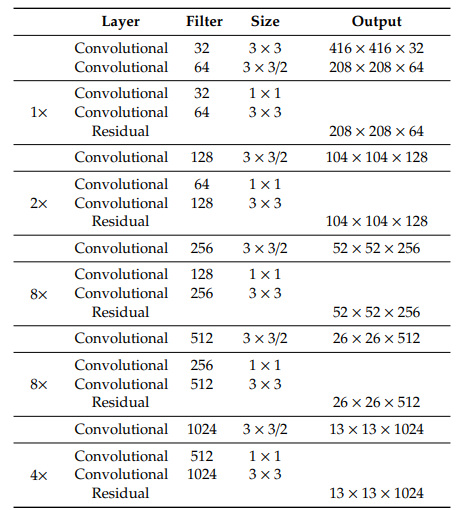

In [38]:
# darknet 53 model 짜기
# yolov3의 feature extraction
def darknet53(input_data):
    input_data = convolutional(input_data, (3, 3, 3, 32)) # 3➙32 (416) . n_ch ( size )
    input_data = convolutional(input_data, (3, 3, 32, 64), down_sample=True) # 32➙64 (416➙208)

    for i in range(1):
        input_data = res_block(input_data, 64, 32, 64) # 64 (208) x1

    input_data = convolutional(input_data, (3, 3, 64, 128), down_sample=True) # 64➙128 (208➙104)
    
    for i in range(2):
        input_data = res_block(input_data, 128, 64, 128) # 128 (104) x2

    input_data = convolutional(input_data, (3, 3, 128, 256), down_sample=True) # 128➙256 (104➙52)

    for i in range(8):
        input_data = res_block(input_data, 256, 128, 256) # 256➙256 (52) x8

    route_1 = input_data # (52) scale out

    input_data = convolutional(input_data, (3, 3, 256, 512), down_sample=True) # 256➙512 (52➙26)

    for i in range(8):
        input_data = res_block(input_data, 512, 256, 512) # 512➙512 (26) x8
        
    route_2 = input_data # (26) scale out
    
    input_data = convolutional(input_data, (3, 3, 512, 1024), down_sample=True) # 512➙1024 (26➙13)

    for i in range(4):
        input_data = res_block(input_data, 1024, 512, 1024) # 1024➙1024 (13) x4

    return route_1, route_2, input_data

# yolov3

In [40]:
# 주석해제 했을때 모델 크기
# Total params: 61,581,727
# Trainable params: 61,529,119
# Non-trainable params: 52,608

# 주석처리 했을때 모델 크기
# Total params: 47,797,663
# Trainable params: 47,755,807
# Non-trainable params: 41,856

## yolov3 모델
def yoloV3(input_layer):
    route_1, route_2, conv = darknet53(input_layer)
    # route_1 : 216 (52)
    # route_2 : 512 (26)
    # conv : 1024 (13)

    conv = convolutional(conv, (1, 1, 1024, 512)) # 1024➙512 (13)
##    
    conv = convolutional(conv, (3, 3, 512, 1024)) 
    conv = convolutional(conv, (1, 1, 1024, 512))
    conv = convolutional(conv, (3, 3, 512, 1024))
    conv = convolutional(conv, (1, 1, 1024, 512))
##
    conv_lobj_branch = convolutional(conv, (3, 3, 512, 1024)) # 512➙1024 (13)
    conv_lbbox = convolutional(conv_lobj_branch,
                               (1, 1, 1024, 3 * (NUM_CLASSES + 5)),
                               activate=False,
                               batch_norm=False) # 1024➙3*(num_class+5) (13)

    conv = convolutional(conv, (1, 1, 512, 256)) # 512➙256 (13)
    conv = upsample(conv) # 256 (26)

    conv = tf.concat([conv, route_2], axis=-1) # 256➙768 (13) (26)
    conv = convolutional(conv, (1, 1, 768, 256)) # 768➙256 (26)
##    
    conv = convolutional(conv, (3, 3, 256, 512)) 
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
##
    conv_mobj_branch = convolutional(conv, (3, 3, 256, 512)) # 256➙512 (26)
    conv_mbbox = convolutional(conv_mobj_branch,
                               (1, 1, 512, 3 * (NUM_CLASSES + 5)),
                               activate=False,
                               batch_norm=False) # 512➙48 (26)

    conv = convolutional(conv, (1, 1, 256, 128)) # 256➙128 (26)
    conv = upsample(conv) # 256➙128 (52)

    conv = tf.concat([conv, route_1], axis=-1) # 128➙384 (52)

    conv = convolutional(conv, (1, 1, 384, 128)) # 384➙128 (52)
##
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
##
    conv_sobj_branch = convolutional(conv, (3, 3, 128, 256)) # 128➙256 (52)
    conv_sbbox = convolutional(conv_sobj_branch,
                               (1, 1, 256, 3 * (NUM_CLASSES + 5)),
                               activate=False,
                               batch_norm=False) # 256➙48 (52)
    return [conv_sbbox, conv_mbbox, conv_lbbox]

# decoder

In [51]:
def decode(conv_out, i= 0):
    """
    feature_maps = [conv_sbbox, conv_mbbox, conv_lbbox]
    conv_sbbox : Bx 13x13x48
    conv_sbbox : Bx 26x26x48
    conv_sbbox : Bx 52x52x48
    """
    
    conv_shape = tf.shape(conv_out)
    batch_size = conv_shape[0]
    output_size = conv_shape[1]

    conv_output = tf.reshape(conv_out, (batch_size, output_size,output_size, 3,5+NUM_CLASSES))
    # Bx 13x13x3x16
    # 13x13 scale
    # 3 Anchor 갯수
    # class_num + 5
    
    conv_raw_dxdy = conv_output[:,:,:,:,0:2] # cx cy
    conv_raw_dwdh = conv_output[:,:,:,:,2:4] # w h
    conv_raw_conf = conv_output[:,:,:,:,4:5] # confidense
    conv_raw_prob = conv_output[:,:,:,:,5:] # 각 클래스별 확률

    y = tf.tile(tf.range(output_size,dtype=tf.int32)[:,tf.newaxis],[1,output_size]) # 행이 0 ➙ output_size("13",26,52) 까지 증가하는 행렬 (13x13)
    x = tf.tile(tf.range(output_size, dtype= tf.int32)[tf.newaxis,:],[output_size,1]) # 열이 0 ➙ output_size("13",26,52) 까지 증가하는 행렬 (13x13)

    xy_grid = tf.concat([x[:,:,tf.newaxis],y[:,:,tf.newaxis]], axis = -1) # 2번 축을 만들어서 x와 y를 2번 축에 대해 concat (13,13,2)
    xy_grid = tf.tile(xy_grid[tf.newaxis,:,:,tf.newaxis,:],[batch_size,1,1,3,1]) # 0번과 3번축을 만들어서 (batch, size, size, Anchor_number, 2) 
    xy_grid = tf.cast(xy_grid,tf.float32)

    pred_xy = (tf.sigmoid(conv_raw_dxdy)+xy_grid)*STRIDES[i] # STRIDES = (8,16,32) 
    pred_wh = (tf.exp(conv_raw_dwdh)*ANCHORS[i])*STRIDES[i]
    pred_xywh = tf.concat([pred_xy,pred_wh], axis = -1)

    pred_conf = tf.sigmoid(conv_raw_conf)
    pred_prob = tf.sigmoid(conv_raw_prob)

    return tf.concat([pred_xywh, pred_conf, pred_prob], axis = -1)

In [52]:
def Model():
    input_layer = tf.keras.layers.Input([416, 416, 3])
    feature_maps = yoloV3(input_layer)
    # feature_maps = [conv_sbbox, conv_mbbox, conv_lbbox]
    # conv_sbbox : 13x13x48
    # conv_sbbox : 26x26x48
    # conv_sbbox : 52x52x48
    bbox_tensors = []

    for i, fm in enumerate(feature_maps):
        bbox_tensor = decode(fm, i)
        bbox_tensors.append(bbox_tensor)

    model = tf.keras.Model(input_layer, bbox_tensors)
    # 	model = Load_weights(model, weight_file)

    return model

In [53]:
model = Model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_150 (Conv2D)            (None, 416, 416, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_144 (Batch  (None, 416, 416, 32  128        ['conv2d_150[0][0]']             
 Normalization)                 )                                                             

                                                                                                  
 batch_normalization_151 (Batch  (None, 104, 104, 64  256        ['conv2d_157[0][0]']             
 Normalization)                 )                                                                 
                                                                                                  
 tf.nn.leaky_relu_151 (TFOpLamb  (None, 104, 104, 64  0          ['batch_normalization_151[0][0]']
 da)                            )                                                                 
                                                                                                  
 conv2d_158 (Conv2D)            (None, 104, 104, 12  73728       ['tf.nn.leaky_relu_151[0][0]']   
                                8)                                                                
                                                                                                  
 batch_nor

                                                                                                  
 tf.__operators__.add_51 (TFOpL  (None, 52, 52, 256)  0          ['tf.__operators__.add_50[0][0]',
 ambda)                                                           'tf.nn.leaky_relu_159[0][0]']   
                                                                                                  
 conv2d_166 (Conv2D)            (None, 52, 52, 128)  32768       ['tf.__operators__.add_51[0][0]']
                                                                                                  
 batch_normalization_160 (Batch  (None, 52, 52, 128)  512        ['conv2d_166[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 tf.nn.leaky_relu_160 (TFOpLamb  (None, 52, 52, 128)  0          ['batch_normalization_160[0][0]']
 da)      

 Normalization)                                                                                   
                                                                                                  
 tf.nn.leaky_relu_168 (TFOpLamb  (None, 52, 52, 128)  0          ['batch_normalization_168[0][0]']
 da)                                                                                              
                                                                                                  
 conv2d_175 (Conv2D)            (None, 52, 52, 256)  294912      ['tf.nn.leaky_relu_168[0][0]']   
                                                                                                  
 batch_normalization_169 (Batch  (None, 52, 52, 256)  1024       ['conv2d_175[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 tf.nn.lea

                                                                                                  
 conv2d_183 (Conv2D)            (None, 26, 26, 256)  131072      ['tf.__operators__.add_59[0][0]']
                                                                                                  
 batch_normalization_177 (Batch  (None, 26, 26, 256)  1024       ['conv2d_183[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 tf.nn.leaky_relu_177 (TFOpLamb  (None, 26, 26, 256)  0          ['batch_normalization_177[0][0]']
 da)                                                                                              
                                                                                                  
 conv2d_184 (Conv2D)            (None, 26, 26, 512)  1179648     ['tf.nn.leaky_relu_177[0][0]']   
          

 da)                                                                                              
                                                                                                  
 conv2d_192 (Conv2D)            (None, 26, 26, 512)  1179648     ['tf.nn.leaky_relu_185[0][0]']   
                                                                                                  
 batch_normalization_186 (Batch  (None, 26, 26, 512)  2048       ['conv2d_192[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 tf.nn.leaky_relu_186 (TFOpLamb  (None, 26, 26, 512)  0          ['batch_normalization_186[0][0]']
 da)                                                                                              
                                                                                                  
 tf.__oper

 ambda)                         )                                 'tf.nn.leaky_relu_193[0][0]']   
                                                                                                  
 conv2d_200 (Conv2D)            (None, 13, 13, 512)  524288      ['tf.__operators__.add_67[0][0]']
                                                                                                  
 batch_normalization_194 (Batch  (None, 13, 13, 512)  2048       ['conv2d_200[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 tf.nn.leaky_relu_194 (TFOpLamb  (None, 13, 13, 512)  0          ['batch_normalization_194[0][0]']
 da)                                                                                              
                                                                                                  
 conv2d_20

 da)                                                                                              
                                                                                                  
 conv2d_211 (Conv2D)            (None, 26, 26, 512)  1179648     ['tf.nn.leaky_relu_203[0][0]']   
                                                                                                  
 batch_normalization_204 (Batch  (None, 26, 26, 512)  2048       ['conv2d_211[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 tf.nn.leaky_relu_204 (TFOpLamb  (None, 26, 26, 512)  0          ['batch_normalization_204[0][0]']
 da)                                                                                              
                                                                                                  
 conv2d_21

                                                                                                  
 tf.nn.leaky_relu_214 (TFOpLamb  (None, 52, 52, 128)  0          ['batch_normalization_214[0][0]']
 da)                                                                                              
                                                                                                  
 conv2d_223 (Conv2D)            (None, 52, 52, 256)  294912      ['tf.nn.leaky_relu_214[0][0]']   
                                                                                                  
 conv2d_215 (Conv2D)            (None, 26, 26, 512)  1179648     ['tf.nn.leaky_relu_207[0][0]']   
                                                                                                  
 conv2d_207 (Conv2D)            (None, 13, 13, 1024  4718592     ['tf.nn.leaky_relu_200[0][0]']   
                                )                                                                 
          

 tf.__operators__.getitem_29 (S  (1, 13)             0           ['tf.range_5[0][0]']             
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_28 (S  (13, 1)             0           ['tf.range_4[0][0]']             
 licingOpLambda)                                                                                  
                                                                                                  
 tf.tile_1 (TFOpLambda)         (52, 52)             0           ['tf.__operators__.getitem_7[0][0
                                                                 ]',                              
                                                                  'tf.__operators__.getitem_1[0][0
                                                                 ]']                              
          

                                                                 ]']                              
                                                                                                  
 tf.__operators__.getitem_10 (S  (1, 52, 52, 1, 2)   0           ['tf.concat_6[0][0]']            
 licingOpLambda)                                                                                  
                                                                                                  
 tf.reshape_1 (TFOpLambda)      (None, 26, 26, 3, 1  0           ['conv2d_216[0][0]',             
                                6)                                'tf.__operators__.getitem_11[0][
                                                                 0]',                             
                                                                  'tf.__operators__.getitem_12[0][
                                                                 0]',                             
          

                                                                                                  
 tf.math.exp_2 (TFOpLambda)     (None, 13, 13, 3, 2  0           ['tf.__operators__.getitem_25[0][
                                )                                0]']                             
                                                                                                  
 tf.__operators__.add_69 (TFOpL  (None, 52, 52, 3, 2  0          ['tf.math.sigmoid[0][0]',        
 ambda)                         )                                 'tf.cast[0][0]']                
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None, 52, 52, 3, 2  0          ['tf.math.exp[0][0]']            
 )                              )                                                                 
                                                                                                  
 tf.__oper

                                1)                               0]']                             
                                                                                                  
 tf.concat_8 (TFOpLambda)       (None, 52, 52, 3, 1  0           ['tf.concat_7[0][0]',            
                                6)                                'tf.math.sigmoid_1[0][0]',      
                                                                  'tf.math.sigmoid_2[0][0]']      
                                                                                                  
 tf.concat_11 (TFOpLambda)      (None, 26, 26, 3, 1  0           ['tf.concat_10[0][0]',           
                                6)                                'tf.math.sigmoid_4[0][0]',      
                                                                  'tf.math.sigmoid_5[0][0]']      
                                                                                                  
 tf.concat

# Loss

In [ ]:
mse_loss = tf.keras.losses.MeanSquaredError() # box loss

bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# bfce_loss = tf.keras.losses.BinaryFocalCrossentropy()
ce_loss = tf.keras.losses.CategoricalCrossentropy()

# sample

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import albumentations as A
import ast
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 416
scale = 1.1
TRAIN_IMAGE_ROOTPATH = "D:visdrone/VisDrone2019-MOT-train/sequences/"
VAL_IMAGE_ROOTPATH = "D:visdrone/VisDrone2019-MOT-val/sequences/"

In [14]:
train_df = pd.read_csv("EDA/train_det_df.csv")

In [15]:
train_df["img_path"] = train_df["img_path"].apply(lambda x : TRAIN_IMAGE_ROOTPATH+x )
# train_df["yolo"] = train_df["yolo"].apply(lambda x : ast.literal_eval(x))
train_df["classes"] = train_df["classes"].apply(lambda x : ast.literal_eval(x))
train_df["target_ids"] = train_df["target_ids"].apply(lambda x : ast.literal_eval(x))

train_df = train_df[["img_path", "height","width","classes","target_ids"]]

In [16]:
train_df.head(2)

,img_path,height,width,classes,target_ids
0,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,756,1344,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 3, 5, 6, 8, 13, 15, 19, 23, 25]"
1,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,756,1344,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 3, 5, 6, 8, 13, 15, 19, 23, 25]"


In [17]:
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.OneOf(
            [
                A.ShiftScaleRotate(
                    rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
                ),
                A.IAAAffine(shear=15, p=0.5, mode="constant"),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=["category_ids"],),
)

test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=["category_ids"]),
)

C:\Users\rh987\AppData\Roaming\Python\Python39\site-packages\albumentations\imgaug\transforms.py:346: FutureWarning: This IAAAffine is deprecated. Please use Affine instead
  warnings.warn("This IAAAffine is deprecated. Please use Affine instead", FutureWarning)


In [55]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, transformer, batch_size=4, train=False, size=416):
        self.df = df.reset_index(drop=True)
        self.train = train
        self.batch_size = batch_size
        self.size = size
        self.transformer = transformer

    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)

    def on_epoch_end(self):
        if self.train:
            self.df = self.df.sample(frac=1.0).reset_index(drop=True)

    def __getitem__(self, idx):
        image_path_batch = self.df.iloc[idx * self.batch_size:(idx + 1) *
                                        self.batch_size].img_path.values
#         boxes_batch = self.df.iloc[idx * self.batch_size:(idx + 1) *
#                                    self.batch_size].yolo.values
#         classes_batch = self.df.iloc[idx * self.batch_size:(idx + 1) *
#                                      self.batch_size].classes.values
#         D = self.df.iloc[idx * self.batch_size:(idx + 1) *
#                                      self.batch_size].target_ids.values.tolist()

        X = np.zeros( (self.batch_size, self.size, self.size, 3) )
#         B,C = [],[]
#         D = np.asarray(D)
        
        for i in range(self.batch_size):
            image = cv2.imread(image_path_batch[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (self.size, self.size))
            
#             boxes = boxes_batch[i]
#             classes = classes_batch[i]
            
#             if self.train:
#                 transformed = self.transformer(image=image, bboxes=boxes, category_ids=classes)
#                 image = transformed["image"] / 255.0
#                 boxes = transformed["bboxes"]
#                 classes = transformed['category_ids']
#             else:
#                 image = cv2.resize(image, (self.size, self.size))
#                 image = image / 255.
            X[i,] = image/255
#             B.append(boxes)
#             C.append(classes)
        
#         B = np.asarray(B)
#         C = np.asarray(C)
        return  X

In [56]:
train_gen = DataGenerator(train_df, transformer=train_transforms, batch_size=4, train=True, size=IMAGE_SIZE)

In [58]:
for x  in train_gen:
    print(x.shape)
    print(x)
    bbox = model(x)
    print(bbox[0])
    break

(4, 416, 416, 3)
[[[[0.63529412 0.68235294 0.7372549 ]
   [0.64313725 0.69019608 0.74509804]
   [0.63921569 0.69019608 0.74509804]
   ...
   [0.21568627 0.30980392 0.08235294]
   [0.21176471 0.30588235 0.07843137]
   [0.19607843 0.28627451 0.0745098 ]]

  [[0.65098039 0.70588235 0.75686275]
   [0.64313725 0.69803922 0.74901961]
   [0.63137255 0.68627451 0.7372549 ]
   ...
   [0.20784314 0.30196078 0.07058824]
   [0.18431373 0.27843137 0.05098039]
   [0.21960784 0.30980392 0.09803922]]

  [[0.54509804 0.6        0.65098039]
   [0.50196078 0.55686275 0.60784314]
   [0.45490196 0.50980392 0.56078431]
   ...
   [0.17647059 0.27058824 0.04313725]
   [0.16078431 0.25490196 0.02745098]
   [0.21568627 0.30588235 0.09411765]]

  ...

  [[0.10196078 0.17254902 0.07843137]
   [0.07843137 0.15294118 0.07058824]
   [0.16078431 0.23137255 0.17254902]
   ...
   [0.17254902 0.28235294 0.10196078]
   [0.21568627 0.32156863 0.16078431]
   [0.07843137 0.18039216 0.03529412]]

  [[0.17647059 0.24705882 0.